# import and constant

In [4]:
import os
import cv2 # type: ignore
import numpy as np # type: ignore
from tqdm import tqdm # type: ignore
import mediapipe as mp # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.preprocessing import LabelEncoder # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore
import joblib # type: ignore

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [1]:
dataset_dir = './dataset_word'
model_name = 'sign_classifier_word'

In [2]:
import tensorflow as tf
print(f"TensorFlow Version: {tf.__version__}")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow Version: 2.20.0
Num GPUs Available:  0


# Dataset

In [5]:
!curl -L -o ./bisindo-40-kata-mp4.zip\
  https://www.kaggle.com/api/v1/datasets/download/anggiyohanespardede/bisindo-40-kata-mp4

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  719M  100  719M    0     0  10.4M      0  0:01:08  0:01:08 --:--:-- 10.9M.9M    0  0:01:09  0:00:56  0:00:13 10.8M


In [6]:
import zipfile
import os
import platform

zip_path = "./bisindo-40-kata-mp4.zip"
extract_dir = "./"

if not os.path.exists(zip_path):
    raise FileNotFoundError(f"❌ File tidak ditemukan: {zip_path}")

print(f"📦 Ekstraksi dataset dari {zip_path} ...")
if platform.system() in ["Windows", "Darwin", "Linux"]:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"✅ Dataset berhasil diekstrak ke {extract_dir}")
else:
    print(f"⚠️ OS {platform.system()} belum dikenali, pastikan unzip dilakukan manual.")


📦 Ekstraksi dataset dari ./bisindo-40-kata-mp4.zip ...
✅ Dataset berhasil diekstrak ke ./


In [7]:
import os
import shutil

src_dir = "raw_video"
dst_dir = dataset_dir

if not os.path.exists(src_dir):
    raise FileNotFoundError(f"❌ Folder sumber tidak ditemukan: {src_dir}")

os.makedirs(dst_dir, exist_ok=True)

print(f"📂 Memindahkan isi dari '{src_dir}' ke '{dst_dir}' ...")

for item in os.listdir(src_dir):
    src_path = os.path.join(src_dir, item)
    dst_path = os.path.join(dst_dir, item)
    
    if os.path.exists(dst_path):
        if os.path.isdir(dst_path):
            shutil.rmtree(dst_path)
        else:
            os.remove(dst_path)

    shutil.move(src_path, dst_path)

print(f"✅ Semua isi dari '{src_dir}' berhasil dipindahkan ke '{dst_dir}'")


📂 Memindahkan isi dari 'raw_video' ke './dataset_word' ...
✅ Semua isi dari 'raw_video' berhasil dipindahkan ke './dataset_word'


In [8]:
import shutil
import os

folder_path = "./raw_video"

if os.path.exists(folder_path):
    print(f"🗑️ Menghapus folder: {folder_path}")
    shutil.rmtree(folder_path)
    print("✅ Folder berhasil dihapus.")
else:
    print("⚠️ Folder tidak ditemukan, tidak ada yang dihapus.")

🗑️ Menghapus folder: ./raw_video
✅ Folder berhasil dihapus.


In [ ]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [6]:
data = []
labels = []

print("🎬 Mulai ekstraksi keypoint dari video...\n")

for label_folder in tqdm(sorted(os.listdir(dataset_dir))):
    folder_path = os.path.join(dataset_dir, label_folder)
    if not os.path.isdir(folder_path):
        continue

    for file in os.listdir(folder_path):
        if not file.lower().endswith(".mp4"):
            continue

        video_path = os.path.join(folder_path, file)
        cap = cv2.VideoCapture(video_path)

        keypoints_seq = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = hands.process(frame)

            hand_keypoints = []

            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks[:2]:  # ambil max 2 tangan
                    hand = [lm_coord for lm in hand_landmarks.landmark for lm_coord in (lm.x, lm.y, lm.z)]
                    hand_keypoints.append(hand)

            # pastikan selalu ada 2 tangan
            while len(hand_keypoints) < 2:
                hand_keypoints.append([0.0]*63)

            keypoints = np.concatenate(hand_keypoints)
            keypoints_seq.append(keypoints)

        cap.release()

        # pad atau trim sequence
        keypoints_seq = np.array(keypoints_seq)
        max_len = 30
        if len(keypoints_seq) < max_len:
            pad = np.zeros((max_len - len(keypoints_seq), keypoints_seq.shape[1]))
            keypoints_seq = np.vstack((keypoints_seq, pad))
        elif len(keypoints_seq) > max_len:
            keypoints_seq = keypoints_seq[:max_len]

        data.append(keypoints_seq)
        labels.append(label_folder)

os.makedirs("preprocessing", exist_ok=True)

output_X_path = os.path.join("preprocessing", "X_word.npy")
output_y_path = os.path.join("preprocessing", "y_word.npy")

np.save(output_X_path, np.array(data))
np.save(output_y_path, np.array(labels))

print(f"\n✅ Ekstraksi selesai:")
print(f"📁 Data disimpan ke: {output_X_path}")
print(f"🏷️ Label disimpan ke: {output_y_path}")
print(f"🧩 Jumlah sampel: {len(data)}")

🎬 Mulai ekstraksi keypoint dari video...



100%|██████████| 40/40 [1:00:06<00:00, 90.16s/it]



✅ Ekstraksi selesai:
📁 Data disimpan ke: preprocessing/X_word.npy
🏷️ Label disimpan ke: preprocessing/y_word.npy
🧩 Jumlah sampel: 2000


In [5]:
X = np.load(os.path.join("preprocessing", "X_word.npy"), allow_pickle=True)
y = np.load(os.path.join("preprocessing", "y_word.npy"), allow_pickle=True)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

joblib.dump(label_encoder, os.path.join("preprocessing", "label_encoder_word.pkl"))

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

print("📊 Data shape:", X_train.shape, y_train.shape)

📊 Data shape: (1600, 30, 126) (1600, 40)


# Train

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [25]:
# --- Model ---
model = Sequential([
    LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')
])

In [26]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 128)            │       130,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,232 (594.66 KB)

 Trainable params: 152,232 (594.66 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# --- Callback ---
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [28]:
# --- Training ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=1000,
    batch_size=32,
    verbose=1
)

Epoch 1/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0444 - loss: 3.5807 - val_accuracy: 0.0675 - val_loss: 3.3323
Epoch 2/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0725 - loss: 3.3509 - val_accuracy: 0.1550 - val_loss: 3.1313
Epoch 3/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1200 - loss: 3.1027 - val_accuracy: 0.1950 - val_loss: 2.7459
Epoch 4/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1612 - loss: 2.7796 - val_accuracy: 0.2050 - val_loss: 2.6796
Epoch 5/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1675 - loss: 2.7258 - val_accuracy: 0.2700 - val_loss: 2.2916
Epoch 6/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2381 - loss: 2.4384 - val_accuracy: 0.3100 - val_loss: 2.2095
Epoch 7/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2506 - loss: 2.3669 - val_accuracy: 0.2775 - val_loss: 2.4030
Epoch 8/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2344 - loss: 2.3935 - val_accu

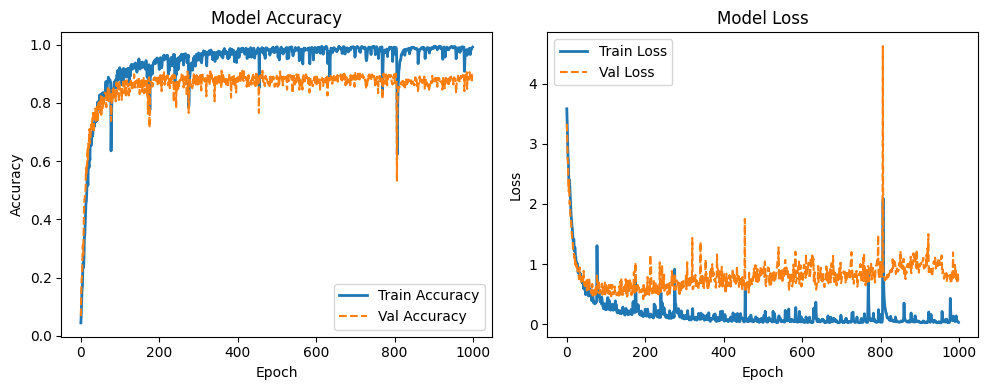

In [29]:
# --- Plot Training ---
plt.figure(figsize=(10, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Val Accuracy', linestyle='--')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linestyle='--')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
os.makedirs("models", exist_ok=True)

model_path = os.path.join("models", f"{model_name}.keras")
label_path = os.path.join("models", f"{model_name}_label.pkl")

model.save(model_path)

with open(label_path, "wb") as f:
    pickle.dump(label_encoder, f)

print(f"✅ Model disimpan sebagai {model_path}")
print(f"✅ Label encoder disimpan sebagai {label_path}")


✅ Model disimpan sebagai models/sign_classifier_word.keras
✅ Label encoder disimpan sebagai models/sign_classifier_word_label.pkl


In [32]:
import tensorflow as tf
import os

os.makedirs("models", exist_ok=True)

converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]

tflite_model = converter.convert()

tflite_path = os.path.join("models", f"{model_name}.tflite")
with open(tflite_path, "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/jr/p2wykk054vn53_ltf2kxs8s80000gn/T/tmpo5ol0flj/assets


INFO:tensorflow:Assets written to: /var/folders/jr/p2wykk054vn53_ltf2kxs8s80000gn/T/tmpo5ol0flj/assets


Saved artifact at '/var/folders/jr/p2wykk054vn53_ltf2kxs8s80000gn/T/tmpo5ol0flj'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 126), dtype=tf.float32, name='keras_tensor_15')
Output Type:
  TensorSpec(shape=(None, 40), dtype=tf.float32, name=None)
Captures:
  13427377936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13427376976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13427379088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13427379664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13427378128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13427378320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13427378512: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1760766667.765441 2178708 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1760766667.765450 2178708 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-10-18 12:51:07.831699: W tensorflow/compiler/mlir/lite/flatbuffer_export.cc:4082] TFLite interpreter needs to link Flex delegate in order to run the model since it contains the following Select TFop(s):
Flex ops: FlexTensorListReserve, FlexTensorListSetItem, FlexTensorListStack
Details:
	tf.TensorListReserve(tensor<2xi32>, tensor<i32>) -> (tensor<!tf_type.variant<tensor<?x128xf32>>>) : {device = ""}
	tf.TensorListSetItem(tensor<!tf_type.variant<tensor<?x128xf32>>>, tensor<i32>, tensor<?x128xf32>) -> (tensor<!tf_type.variant<tensor<?x128xf32>>>) : {device = "", resize_if_index_out_of_bounds = false}
	tf.TensorListStack(tensor<!tf_type.variant<tensor<?x128xf32>>>, tensor<2xi32>) -> (tensor<1x?x128xf32>) : {device = "", num_elements = 1 : i64}
See instructions: https://www.tensorflow.org